# 2. Studienarbeit in Reinforcement Learning

<a id="0"></a>
 # Gliederung
0. [Imports](#1)     
2. [Validate & Register Environment](#2) 
3. [Hyperparameter optimization using Optuna](#3) 
    - [Run optimization](#3a)
4. [Model training](#4)
    - [Interpretation eines Modells](#4a)
    - [Modell über den Verlauf einer Saison](#4b)
5. [Modellanwendung](#5)
6. ["Beat the bookmaker"](#6)
    - [Vergleich des Modells mit Wettquoten](#6a)
    - [Wett-Stategien auf Basis des Modells](#6b)
7. [Clustering der Spieler](#7)
    - [KMeans-Clustering](#7a)
    - [Ex-Post_Analyse der Cluster](#7b)

## Imports<a class="anchor" id="1"></a>


In [1]:
%load_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
import optuna
import CurvyRaceEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3 import DDPG,SAC, TD3, A2C, PPO

import gymnasium
from gymnasium.envs.registration import register

import pandas as pd
import optuna

import torch
import torch.nn as nn
import time

%matplotlib inline
%reload_ext autoreload

c:\Users\schmidtfa\MasterStudium\PythonEnvironment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Validate & Register Environment<a class="anchor" id="2"></a>


In [2]:
test = CurvyRaceEnv.CurvyRaceEnv()
check_env(test)
ENV_ID = "CurvyRaceEnv-v0"
register(
     id=ENV_ID,
     entry_point="CurvyRaceEnv:CurvyRaceEnv",
     max_episode_steps=100,
)

c:\Users\schmidtfa\MasterStudium\PythonEnvironment\Lib\site-packages\stable_baselines3\common\env_checker.py:441: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


## Hyperparameter optimization using Optuna <a class="anchor" id="3"></a>

In [3]:
def evaluate_model(model, env, num_episodes=100):  
    """
    Evaluates the performance of a reinforcement learning model over a specified number of episodes.

    Parameters:
    - model: The reinforcement learning model to be evaluated.
    - env: The environment in which the model is evaluated.
    - num_episodes (int): The number of episodes to run for evaluation. Defaults to 100.

    Returns:
    float: The mean reward achieved by the model over the specified number of episodes.

    Example:
    >>> trained_model = ...  # Initialize or load your trained model
    >>> environment = ...  # Initialize your environment
    >>> mean_reward = evaluate_model(trained_model, environment, num_episodes=50)
    >>> print(mean_reward)
    """    
    total_reward = 0.0
    for _ in range(num_episodes):
        obs, info = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done,info, _ = env.step(action)
            total_reward += reward
    mean_reward = total_reward / num_episodes
    return mean_reward

In [19]:
def objective(trial: optuna.Trial, model, timesteps) -> float:   
    """
    This function defines the objective for the Optuna hyperparameter optimization.
    It creates an environment, initializes a reinforcement learning model based on the specified type,
    trains the model, and evaluates its performance based on a given number of timesteps.

    Parameters:
    - trial (optuna.Trial): An Optuna Trial object providing hyperparameter suggestions.
    - model (str): The type of reinforcement learning model to use. Supported options: "DDPG", "TD3", "SAC", "A2C", "PPO".
    - timesteps (int): The total number of training timesteps for the reinforcement learning model.

    Returns:
    float: The mean reward achieved by the trained model.

    Raises:
    ValueError: If an unsupported model type is provided.

    Example:
    >>> study_model = "SAC"
    >>> study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
    >>> study.optimize(objective(study_model, 10000), n_trials=10000, show_progress_bar=True)
    """
    # Create Environment
    env = gymnasium.make(ENV_ID)  
    
    # Create a model
    match model:
        case "DDPG":
            hyperparams = {
            'learning_starts': trial.suggest_int('learning_starts', 50,400),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
            'gamma': trial.suggest_float('gamma', 0.9, 0.999),
            'tau': trial.suggest_float('tau', 1e-3, 1e-1, log=True),
            'batch_size': trial.suggest_int('batch_size', 16,1024),        
            }
            model = DDPG('MlpPolicy', env, **hyperparams,
                 action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)))
        case "TD3":
            hyperparams = {
            'learning_starts': trial.suggest_int('learning_starts', 50,400),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
            'gamma': trial.suggest_float('gamma', 0.9, 0.999),
            'tau': trial.suggest_float('tau', 1e-3, 1e-1, log=True),
            'batch_size': trial.suggest_int('batch_size', 16,1024),        
            }
            model = TD3('MlpPolicy', env, **hyperparams,
                 action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)))

        case "SAC":
            hyperparams = {
            'learning_starts': trial.suggest_int('learning_starts', 50,400),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
            'gamma': trial.suggest_float('gamma', 0.9, 0.999),
            'tau': trial.suggest_float('tau', 1e-3, 1e-1, log=True),
            'batch_size': trial.suggest_int('batch_size', 16,1024),        
            }
            model = SAC('MlpPolicy', env, **hyperparams,
                 action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)))

        case "A2C":
            hyperparams = {
            'learning_starts': trial.suggest_int('learning_starts', 50,400),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
            'gamma': trial.suggest_float('gamma', 0.9, 0.999),
            'tau': trial.suggest_float('tau', 1e-3, 1e-1, log=True),
            'batch_size': trial.suggest_int('batch_size', 16,1024),        
            }
            model = A2C('MlpPolicy', env, **hyperparams,
                )

        case "PPO":
            hyperparams = {
            'learning_starts': trial.suggest_int('learning_starts', 50,400),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
            'gamma': trial.suggest_float('gamma', 0.9, 0.999),
            'tau': trial.suggest_float('tau', 1e-3, 1e-1, log=True),
            'batch_size': trial.suggest_int('batch_size', 16,1024),        
            }
            model = PPO('MlpPolicy', env, **hyperparams)        
        case _:
             
            print("Unsupported model. Try DDPG, TD3, SAC, A2C or PPO instead")
            return
    
    # Train the model
    model.learn(total_timesteps=timesteps)  # Adjust the total_timesteps as needed

    # Evaluate the model
    mean_reward = evaluate_model(model, env)
    env.close()
    return mean_reward

### Run optimization <a class="anchor" id="3a"></a>

In [20]:
study_model = "SAC"
study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
study.optimize(lambda trial: objective(trial=trial, model=study_model, timesteps=400), n_trials=10, show_progress_bar=True)

study_model = "DDPG"
study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
study.optimize(lambda trial: objective(trial=trial, model=study_model, timesteps=400), n_trials=10, show_progress_bar=True)

study_model = "TD3"
study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
study.optimize(lambda trial: objective(trial=trial, model=study_model, timesteps=400), n_trials=10, show_progress_bar=True)

study_model = "A2C"
study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
study.optimize(lambda trial: objective(trial=trial, model=study_model, timesteps=400), n_trials=10, show_progress_bar=True)

study_model = "PPO"
study = optuna.create_study(study_name=study_model, storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
study.optimize(lambda trial: objective(trial=trial, model=study_model, timesteps=400), n_trials=10, show_progress_bar=True)

[I 2024-01-26 15:23:11,696] Using an existing study with name 'A2C' instead of creating a new one.
  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\schmidtfa\MasterStudium\PythonEnvironment\Lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
Best trial: 5. Best value: -19.3865:  10%|█         | 1/10 [00:07<01:03,  7.01s/it]

[I 2024-01-26 15:23:18,701] Trial 5 finished with value: -19.386505303492203 and parameters: {'learning_rate': 0.0344130357593572, 'gamma': 0.9531028687852321}. Best is trial 5 with value: -19.386505303492203.


Best trial: 6. Best value: 71.9773:  20%|██        | 2/10 [00:14<00:56,  7.02s/it] 

[I 2024-01-26 15:23:25,733] Trial 6 finished with value: 71.97730067344624 and parameters: {'learning_rate': 0.0009628534112561078, 'gamma': 0.9725866365811318}. Best is trial 6 with value: 71.97730067344624.


Best trial: 6. Best value: 71.9773:  30%|███       | 3/10 [00:21<00:51,  7.31s/it]

[I 2024-01-26 15:23:33,375] Trial 7 finished with value: -14.83918744439077 and parameters: {'learning_rate': 1.1090757204657881e-05, 'gamma': 0.9060810741624848}. Best is trial 6 with value: 71.97730067344624.


Best trial: 6. Best value: 71.9773:  40%|████      | 4/10 [00:28<00:43,  7.17s/it]

[I 2024-01-26 15:23:40,337] Trial 8 finished with value: -24.030802082444712 and parameters: {'learning_rate': 0.00043662176633010554, 'gamma': 0.9676945239936985}. Best is trial 6 with value: 71.97730067344624.


Best trial: 6. Best value: 71.9773:  50%|█████     | 5/10 [00:35<00:35,  7.05s/it]

[I 2024-01-26 15:23:47,158] Trial 9 finished with value: -9.865740597840254 and parameters: {'learning_rate': 0.0001474938393042847, 'gamma': 0.9361505396077017}. Best is trial 6 with value: 71.97730067344624.


Best trial: 6. Best value: 71.9773:  60%|██████    | 6/10 [00:42<00:28,  7.00s/it]

[I 2024-01-26 15:23:54,082] Trial 10 finished with value: 26.826588473189645 and parameters: {'learning_rate': 0.00046984945302527966, 'gamma': 0.9473229662294349}. Best is trial 6 with value: 71.97730067344624.


Best trial: 6. Best value: 71.9773:  70%|███████   | 7/10 [00:49<00:20,  6.96s/it]

[I 2024-01-26 15:24:00,961] Trial 11 finished with value: -49.27544985645975 and parameters: {'learning_rate': 0.024269706417991633, 'gamma': 0.9228684715295001}. Best is trial 6 with value: 71.97730067344624.


Best trial: 6. Best value: 71.9773:  80%|████████  | 8/10 [00:56<00:13,  6.91s/it]

[I 2024-01-26 15:24:07,749] Trial 12 finished with value: -7.271123895595495 and parameters: {'learning_rate': 5.776132355869791e-05, 'gamma': 0.9290726671786439}. Best is trial 6 with value: 71.97730067344624.


Best trial: 6. Best value: 71.9773:  90%|█████████ | 9/10 [01:03<00:06,  6.92s/it]

[I 2024-01-26 15:24:14,659] Trial 13 finished with value: 35.143294871150836 and parameters: {'learning_rate': 0.0004339219745686147, 'gamma': 0.9685958648670738}. Best is trial 6 with value: 71.97730067344624.


Best trial: 6. Best value: 71.9773: 100%|██████████| 10/10 [01:10<00:00,  7.06s/it]
[I 2024-01-26 15:24:22,391] A new study created in RDB with name: PPO


[I 2024-01-26 15:24:22,272] Trial 14 finished with value: 24.951741632938873 and parameters: {'learning_rate': 0.0010729974758402568, 'gamma': 0.9526371739765297}. Best is trial 6 with value: 71.97730067344624.


Best trial: 0. Best value: 32.2919:  10%|█         | 1/10 [00:09<01:26,  9.65s/it]

[I 2024-01-26 15:24:32,027] Trial 0 finished with value: 32.29187446789845 and parameters: {'learning_rate': 0.05803500150266951, 'gamma': 0.9353780631262674}. Best is trial 0 with value: 32.29187446789845.


Best trial: 0. Best value: 32.2919:  20%|██        | 2/10 [00:19<01:16,  9.58s/it]

[I 2024-01-26 15:24:41,565] Trial 1 finished with value: 30.957776347081058 and parameters: {'learning_rate': 0.002907207628173243, 'gamma': 0.925680978058909}. Best is trial 0 with value: 32.29187446789845.


Best trial: 0. Best value: 32.2919:  30%|███       | 3/10 [00:28<01:06,  9.53s/it]

[I 2024-01-26 15:24:51,013] Trial 2 finished with value: -9.899266824773338 and parameters: {'learning_rate': 0.00010354095353081427, 'gamma': 0.9066595819327685}. Best is trial 0 with value: 32.29187446789845.


Best trial: 0. Best value: 32.2919:  40%|████      | 4/10 [00:38<00:58,  9.75s/it]

[I 2024-01-26 15:25:01,114] Trial 3 finished with value: 15.267570613803695 and parameters: {'learning_rate': 0.011423512477295053, 'gamma': 0.9579084272491408}. Best is trial 0 with value: 32.29187446789845.


Best trial: 0. Best value: 32.2919:  50%|█████     | 5/10 [00:47<00:47,  9.53s/it]

[I 2024-01-26 15:25:10,260] Trial 4 finished with value: 30.351239348102382 and parameters: {'learning_rate': 0.0009735978750275497, 'gamma': 0.9224900250681013}. Best is trial 0 with value: 32.29187446789845.


Best trial: 0. Best value: 32.2919:  60%|██████    | 6/10 [00:58<00:39,  9.82s/it]

[I 2024-01-26 15:25:20,651] Trial 5 finished with value: -4.402706476989204 and parameters: {'learning_rate': 7.432985729134075e-05, 'gamma': 0.9524144061107048}. Best is trial 0 with value: 32.29187446789845.


Best trial: 0. Best value: 32.2919:  70%|███████   | 7/10 [01:09<00:31, 10.41s/it]

[I 2024-01-26 15:25:32,260] Trial 6 finished with value: -61.10873691880266 and parameters: {'learning_rate': 0.09482632846159744, 'gamma': 0.9336894258297469}. Best is trial 0 with value: 32.29187446789845.


Best trial: 0. Best value: 32.2919:  80%|████████  | 8/10 [01:19<00:20, 10.01s/it]

[I 2024-01-26 15:25:41,410] Trial 7 finished with value: 23.58421539295242 and parameters: {'learning_rate': 0.0008117024465315339, 'gamma': 0.9631114256115249}. Best is trial 0 with value: 32.29187446789845.


Best trial: 8. Best value: 44.5314:  90%|█████████ | 9/10 [01:28<00:09,  9.79s/it]

[I 2024-01-26 15:25:50,707] Trial 8 finished with value: 44.531351205579774 and parameters: {'learning_rate': 0.004817183306733329, 'gamma': 0.9637162350648378}. Best is trial 8 with value: 44.531351205579774.


Best trial: 8. Best value: 44.5314: 100%|██████████| 10/10 [01:37<00:00,  9.75s/it]

[I 2024-01-26 15:25:59,868] Trial 9 finished with value: -4.141626513272463 and parameters: {'learning_rate': 3.6803624245023464e-05, 'gamma': 0.9929962158654418}. Best is trial 8 with value: 44.531351205579774.


## Model training <a class="anchor" id="4"></a>

In [45]:
def learn_model(env, model, hyperparameters, timesteps, monitor_dir, model_dir):
    """
    Trains a reinforcement learning model in the specified environment using the given hyperparameters and saves the trained model.

    Parameters:
    - env: The environment in which the model is trained.
    - model (str): The type of reinforcement learning model to be trained. Supported options: "DDPG", "TD3", "SAC", "A2C", "PPO".
    - hyperparameters: Dictionary containing hyperparameters for the specified model.
    - timesteps (int): The total number of training timesteps.
    - monitor_dir (str): The directory for monitoring the training progress.
    - model_dir (str): The directory to save the trained model.

    Returns:
    None

    Example:
    >>> environment = ...  # Initialize your environment
    >>> model_type = "DDPG"
    >>> hyperparams = {'learning_starts': 50, 'learning_rate': 1e-4, 'gamma': 0.99, 'tau': 0.001, 'batch_size': 64}
    >>> total_timesteps = 10000
    >>> monitor_directory = "/path/to/monitor"
    >>> model_directory = "/path/to/save/model"
    >>> learn_model(environment, model_type, hyperparams, total_timesteps, monitor_directory, model_directory)
    """
    env = Monitor(env, monitor_dir)

    match model:
        case "DDPG":
            model = DDPG(env=env, policy="MlpPolicy", **hyperparameters)
        case "TD3":
            model = TD3(env = env, policy="MlpPolicy" ,**hyperparameters)

        case "SAC":
            model = SAC(env = env, policy="MlpPolicy", **hyperparameters)

        case "A2C":
            model = A2C(env = env, policy="MlpPolicy", **hyperparameters)

        case "PPO":
            model = PPO(env = env, policy="MlpPolicy", **hyperparameters)        
        case _:
            print("Unsupported model. Try DDPG, TD3, SAC, A2C or PPO instead")
            return
    
    model.learn(total_timesteps=timesteps)
    model.save(model_dir)
    env.close()
    _, _ = env.reset()
    del model


In [46]:
def load_best_paramerters(study_name, storage):
    """
    Loads the best hyperparameters from an Optuna study.

    Parameters:
    - study_name (str): The name of the Optuna study.
    - storage (str): The storage URL for the Optuna study.

    Returns:
    dict: A dictionary containing the best hyperparameters from the study.

    Example:
    >>> study_name = "my_study"
    >>> storage_url = "sqlite:///example.db"
    >>> best_parameters = load_best_parameters(study_name, storage_url)
    >>> print(best_parameters)
    """
    loaded_study = optuna.load_study(study_name=study_name, storage=storage)
    best_params = loaded_study.best_trial.params
    return best_params

In [55]:
env = gymnasium.make(ENV_ID)
ddpg_params = load_best_paramerters("DDPG", "sqlite:///DRL2.db")
learn_model(env=env, model="DDPG", hyperparameters=ddpg_params, timesteps=1000, monitor_dir="logs/ddpg", model_dir="models/ddpg")

td3_params = load_best_paramerters("TD3", "sqlite:///DRL2.db")
learn_model(env = env, model="TD3", hyperparameters=td3_params, timesteps=1000, monitor_dir="logs/td3", model_dir="models/td3")

a2c_params = load_best_paramerters("A2C", "sqlite:///DRL2.db")
learn_model(env = env, model="A2C", hyperparameters=a2c_params, timesteps=1000, monitor_dir="logs/a2c", model_dir="models/a2c")

ppo_params = load_best_paramerters("PPO", "sqlite:///DRL2.db")
learn_model(env = env, model="PPO", hyperparameters=ppo_params, timesteps=1000, monitor_dir="logs/ppo", model_dir="models/ppo")

sac_params = load_best_paramerters("SAC", "sqlite:///DRL2.db")
learn_model(env = env, model="SAC", hyperparameters=sac_params, timesteps=10000, monitor_dir="logs/sac", model_dir="models/sac")


c:\Users\schmidtfa\MasterStudium\PythonEnvironment\Lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(


In [56]:
def run_env(env, model):
    """
    Runs the specified reinforcement learning model in the given environment.

    Parameters:
    - env: The environment in which the model is run.
    - model: The reinforcement learning model to be run in the environment.

    Returns:
    None

    Example:
    >>> environment = ...  # Initialize your environment
    >>> trained_model = ...  # Initialize or load your trained model
    >>> run_env(environment, trained_model)
    """
    obs, info = env.reset()
    done = False
    reward_list = []
    observation_list = []
    while not done:
        action, _states = model.predict(obs)
        obs, rewards, done, info, _ = env.step(action)
        observation_list.append(obs)
        reward_list.append(rewards)
    print("Final state:")
    env.render()
    return 

In [57]:
def plot_cumulative_rewards(rewards):
    """
    Plots the cumulative rewards over episodes for different keys.

    Parameters:
    - rewards (dict): A dictionary where keys represent different series and values are lists of rewards.

    Returns:
    None

    Example:
    >>> rewards_data = {'Series1': [1, 3, 5, 2], 'Series2': [2, 4, 6, 8]}
    >>> plot_cumulative_rewards(rewards_data)
    """
    
    # Calculate the cumulative sum of the list elements
    cumulative_rewards = {key: np.cumsum(value) for key, value in rewards.items()}

    # Plot the cumulative rewards
    for key, value in cumulative_rewards.items():
        plt.plot(value, label=key)

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.show()


In [58]:
def load_log(path):
    """
    Parameters:
    - path (str): The file path to the CSV file containing training data.

    Returns:
    list: A list of numerical values extracted from the CSV file, which represent the return of an episode.

    Example:
    >>> file_path = "path/to/numeric_data.csv"
    >>> numeric_data = load_log(file_path)
    >>> print(numeric_data)
    """

    data =  pd.read_csv(path, index_col=None).index.tolist()[1:]    
    return [float(x) for x in data]

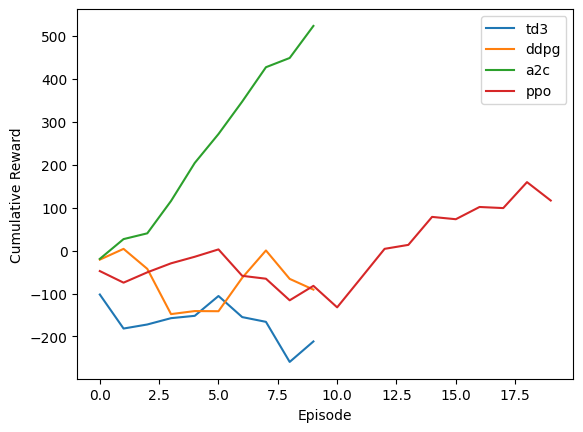

In [59]:
test = gymnasium.make(ENV_ID)
sac = SAC.load("models/model_sac.zip")
td3 = TD3.load("models/td3.zip")
ddpg = DDPG.load("models/ddpg.zip")
ppo = PPO.load("models/ppo.zip")
a2c = A2C.load("models/a2c.zip")

rewards = {}
rewards["td3"] = load_log("logs/td3.monitor.csv")
rewards["sac"] = load_log("logs/sac.monitor.csv")
rewards["ddpg"] = load_log("logs/ddpg.monitor.csv")
rewards["a2c"] = load_log("logs/a2c.monitor.csv")
rewards["ppo"] = load_log("logs/ppo.monitor.csv")

plot_cumulative_rewards(rewards)

c:\Users\schmidtfa\MasterStudium\PythonEnvironment\Lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(


Final state:


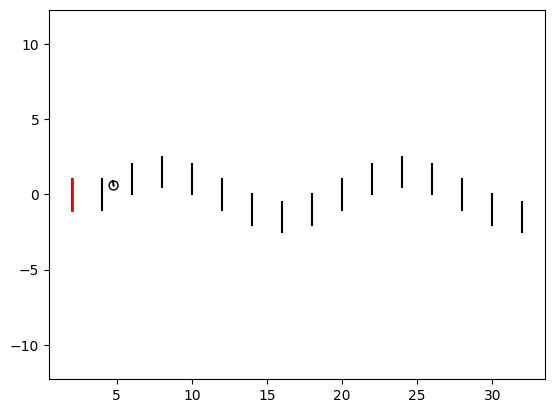

In [60]:
run_env(test, a2c)

In [61]:
evaluate_model(a2c, test)

58.93420198226698